In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np


In [9]:
import sys
sys.path.insert(1, '/Users/ryanr/Documents/PhD/coding/Kepler/pipelines/')
from K2TranPixCode import *

In [10]:
def Motion_correction(Data,Mask,Thrusters,Dist):
    """
    Atempts to correct for telescope motion between individual thruster firings.
    A spline is first fitted to the stable points, and subtracted from the data.
    Next a cubic is fitted into a thruster firing interval and subtracted from the
    original data. 
    There is a check on the second derivative to ientify points that appear to not
    follow the general trend and so should not be used in fitting the cubic.

    This method still has some issues, for instance it doesn't seem to work on 
    C03 or C10.
    """
    Corrected = np.zeros((Data.shape[0],Data.shape[1],Data.shape[2]))
    Motion_flag = np.zeros(Data.shape[0])
    fit = np.zeros(len(Data))
    X = np.where(Mask == 1)[0]
    Y = np.where(Mask == 1)[1]
    for j in range(len(X)):
        temp = np.copy(Data[:,X[j],Y[j]])
        zz = np.arange(0,len(Data))
        AvSplineind = []
        for i in range(len(Thrusters)-1):
            beep = []
            beep = Dist[Thrusters[i]+1:Thrusters[i+1]-1]
            if (beep < 0.3).any():
                datrange = Data[Thrusters[i]+1:Thrusters[i+1]-1,X[j],Y[j]]
                # Need to make sure most stable frame isnt skewed by a cosmic ray or asteroid. 
                # make a standard deviation cut on all points in the thruster interval,
                # then reset all values which exceed by either the average of its neighbours, 
                # or neigbour value for frings cases.
                lim = np.nanmedian(datrange)+3*np.nanstd(datrange)
                ind = np.where(datrange > lim)[0]
                for index in ind:
                    if (index < len(datrange) - 1) & (index > 0):
                        datrange[index] = np.nanmedian([datrange[index-1],datrange[index+1]])
                    elif (index == 0):
                        datrange[index] = datrange[index+1]
                    elif (index >= len(datrange)-1):
                        datrange[index] = datrange[index-1]
                        

                val = Data[np.where(beep == np.nanmin(beep))[0][0]+Thrusters[i]+1,X[j],Y[j]]
                #if val < np.nanmedian(datrange) + 2*np.nanstd(datrange):
                AvSplineind.append(np.where(beep == np.nanmin(beep))[0][0]+Thrusters[i]+1)
            else:
                Motion_flag[Thrusters[i]+1:Thrusters[i+1]-1] = 1
        AvSplineind = np.array(AvSplineind)

        if len(AvSplineind) > 1:
            AvSplinepoints = np.copy(Data[AvSplineind,X[j],Y[j]])
            Splinef = interp1d(AvSplineind, AvSplinepoints, kind='linear', fill_value=np.nan, bounds_error = False)
            Spline = Splinef(zz)

            for i in range(len(Thrusters)-1):

                if abs(Thrusters[i]-Thrusters[i+1]) > 5:
                    try:
                        Section = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]]) - Spline[Thrusters[i]+2:Thrusters[i+1]]
                        temp2 = np.copy(Section)
                        #temp2[Spline[Thrusters[i]+2:Thrusters[i+1]] == -1e10] = np.nan
                        x = np.arange(0,len(Section))
                        limit =np.nanmedian(np.diff(np.diff(Section)))+2.5*np.nanstd(np.diff(np.diff(Section)))
                        yo = np.where(np.diff(np.diff(Section))>limit)[0]
                        
                        if len(yo)/2 == int(len(yo)/2):
                            z = 0
                            while z + 1 < len(yo):
                                yoarr = np.arange(yo[z],yo[z+1])
                                temp2[yoarr] = np.nan
                                yo = np.delete(yo,[0,1])
                        else:
                            z = 0
                            while z + 2 < len(yo):
                                yoarr = np.arange(yo[z],yo[z+1])
                                temp2[yoarr] = np.nan
                                yo = np.delete(yo,[0,1])
                        if len(yo) == 1:
                            temp2[yo] = np.nan
                        
                        ind = np.where(~np.isnan(temp2))[0]

                        if (len(x[ind]) > 3) & (len(x[ind])/len(x) > 0.6):
                            polyfit, resid, _, _, _  = np.polyfit(x[ind], Section[ind], 3, full = True)
                            p3 = np.poly1d(polyfit)
                            original_data = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]])
                            reduced_data = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]]) - p3(x) 

                            #chi = np.nansum((original_data-(p3(x)))**2/())
                            #chir = chi/(len(Flux)-2)
                            #pval = 1 - stats.chi2.cdf(chir,1)
                            #if pval > 0.6:

                            if abs(np.nanmedian(original_data) - np.nanmedian(reduced_data))/np.nanstd(original_data) < 2:
                                temp[x+Thrusters[i]+2] = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]]) - p3(x) 
                                temp[Thrusters[i]:Thrusters[i]+2] = np.nan
                        # This should kill all instances of uncorrected data due to drift systematically being > 0.3 pix
                        if (np.isnan(Spline[Thrusters[i]+2:Thrusters[i+1]])).all():
                            temp[x+Thrusters[i]+2] = np.nan
                    except RuntimeError:
                        pass

        Corrected[:,X[j],Y[j]] = temp                    
    return Corrected, Motion_flag

In [11]:
pixelfile = '../../Data/ktwo201495875-c01_lpd-targ.fits.gz'

In [12]:
hdu = fits.open(pixelfile)

if len(hdu) > 1:
    dat = hdu[1].data
else:
    print('Broken file ', pixelfile)
datacube = fits.ImageHDU(hdu[1].data.field('FLUX')[:]).data
if datacube.shape[1] > 1 and datacube.shape[2] > 1:
    datacube = Clip_cube(datacube)

    time = dat["TIME"] + 2454833.0
    Qual = hdu[1].data.field('QUALITY')
    thrusters = np.where((Qual == 1048576) | (Qual == 1089568) | (Qual == 1056768) | (Qual == 1064960) | (Qual == 1081376) | (Qual == 10240) | (Qual == 32768) | (Qual == 1097760) | (Qual == 1048580) | (Qual == 1081348))[0]
    thrusters = np.insert(thrusters,0,-1)
    thrusters = np.append(thrusters,len(datacube)-2)
    quality = np.where(Qual != 0)[0]

    xdrif = dat['pos_corr1']
    ydrif = dat['pos_corr2']
    distdrif = np.sqrt(xdrif**2 + ydrif**2)
    if len(distdrif) != len(datacube):
        err_string = 'Distance arr is too short for {file}: len = {leng}'.format(file = pixelfile, leng = len(distdrif))
        raise ValueError(err_string) 

    goodthrust = thrusters[np.where(distdrif[thrusters]<0.2)]
    #calculate the reference frame
    if len(goodthrust) > 4:
        Framemin = goodthrust[3]+1
    elif len(goodthrust) > 0:
        Framemin = goodthrust[0]+1
    else:
        Framemin = 100 # Arbitrarily chosen, Data is probably screwed anway if there are no thruster firings.
    # Apply object mask to data
    Mask = ThrustObjectMask(datacube,goodthrust)

    #Maskdata, ast = First_pass(np.copy(datacube),Qual,quality,thrusters,pixelfile)
    Maskdata = np.copy(datacube)
    allMask = np.ones((datacube.shape[1],datacube.shape[2]))

In [13]:
Maskdata, Motion_flag = Motion_correction(Maskdata,allMask,thrusters,np.copy(distdrif))

In [32]:
ind = np.where(distdrif< 0.2)[0]

<IPython.core.display.Javascript object>


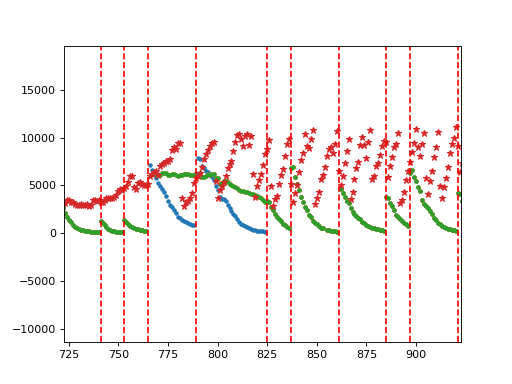

(400, 600)

In [33]:
plt.figure()
plt.plot(datacube[:,7,7],'.')
plt.plot(Maskdata[:,7,7],'.')
plt.plot(Corrected[:,7,7],'.')
plt.plot(datacube[ind,7,7],'*')
for t in thrusters:
    plt.axvline(t,ls='--',color='red')
plt.xlim(400,600)

<IPython.core.display.Javascript object>


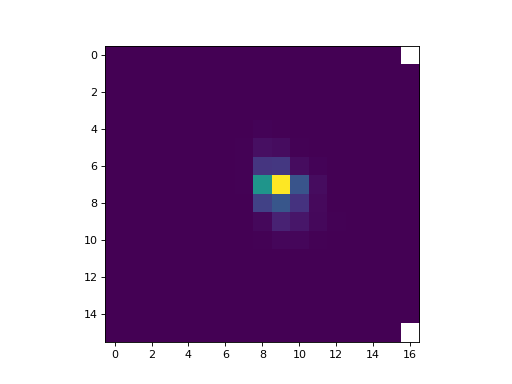

In [20]:
plt.figure()
plt.imshow(datacube[1000])

In [25]:
Data = datacube.copy()
Mask = allMask
Thrusters = thrusters
Dist = np.copy(distdrif)


Corrected = np.zeros((Data.shape[0],Data.shape[1],Data.shape[2]))
Motion_flag = np.zeros(Data.shape[0])
fit = np.zeros(len(Data))
X = np.where(Mask == 1)[0]
Y = np.where(Mask == 1)[1]
for j in range(len(X)):
    temp = np.copy(Data[:,X[j],Y[j]])
    zz = np.arange(0,len(Data))
    AvSplineind = []
    for i in range(len(Thrusters)-1):
        beep = []
        beep = Dist[Thrusters[i]+1:Thrusters[i+1]-1]
        if (beep < 0.3).any():
            datrange = Data[Thrusters[i]+1:Thrusters[i+1]-1,X[j],Y[j]]
            # Need to make sure most stable frame isnt skewed by a cosmic ray or asteroid. 
            # make a standard deviation cut on all points in the thruster interval,
            # then reset all values which exceed by either the average of its neighbours, 
            # or neigbour value for frings cases.
            lim = np.nanmedian(datrange)+3*np.nanstd(datrange)
            ind = np.where(datrange > lim)[0]
            for index in ind:
                if (index < len(datrange) - 1) & (index > 0):
                    datrange[index] = np.nanmedian([datrange[index-1],datrange[index+1]])
                elif (index == 0):
                    datrange[index] = datrange[index+1]
                elif (index >= len(datrange)-1):
                    datrange[index] = datrange[index-1]


            val = Data[np.where(beep == np.nanmin(beep))[0][0]+Thrusters[i]+1,X[j],Y[j]]
            #if val < np.nanmedian(datrange) + 2*np.nanstd(datrange):
            AvSplineind.append(np.where(beep == np.nanmin(beep))[0][0]+Thrusters[i]+1)
        else:
            Motion_flag[Thrusters[i]+1:Thrusters[i+1]-1] = 1
    AvSplineind = np.array(AvSplineind)

    if len(AvSplineind) > 1:
        AvSplinepoints = np.copy(Data[AvSplineind,X[j],Y[j]])
        Splinef = interp1d(AvSplineind, AvSplinepoints, kind='linear', fill_value=np.nan, bounds_error = False)
        Spline = Splinef(zz)

        for i in range(len(Thrusters)-1):

            if abs(Thrusters[i]-Thrusters[i+1]) > 5:
                try:
                    Section = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]]) - Spline[Thrusters[i]+2:Thrusters[i+1]]
                    temp2 = np.copy(Section)
                    #temp2[Spline[Thrusters[i]+2:Thrusters[i+1]] == -1e10] = np.nan
                    x = np.arange(0,len(Section))
                    

                    ind = np.where(~np.isnan(temp2))[0]

                    if (len(x[ind]) > 3) & (len(x[ind])/len(x) > 0.6):
                        polyfit, resid, _, _, _  = np.polyfit(x[ind], Section[ind], 3, full = True)
                        p3 = np.poly1d(polyfit)
                        original_data = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]])
                        reduced_data = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]]) - p3(x) 

                        #chi = np.nansum((original_data-(p3(x)))**2/())
                        #chir = chi/(len(Flux)-2)
                        #pval = 1 - stats.chi2.cdf(chir,1)
                        #if pval > 0.6:

                        if abs(np.nanmedian(original_data) - np.nanmedian(reduced_data))/np.nanstd(original_data) < 2:
                            temp[x+Thrusters[i]+2] = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]]) - p3(x) 
                            temp[Thrusters[i]:Thrusters[i]+2] = np.nan
                    # This should kill all instances of uncorrected data due to drift systematically being > 0.3 pix
                    if (np.isnan(Spline[Thrusters[i]+2:Thrusters[i+1]])).all():
                        temp[x+Thrusters[i]+2] = np.nan
                except RuntimeError:
                    pass

    Corrected[:,X[j],Y[j]] = temp                    

In [34]:
import pywt

In [610]:
np.isfinite(datacube[:,7,7]).shape

(4022,)

In [608]:
nonan = datacube[np.isfinite(datacube[:,7,7]),7,7]
nonanthrust = thrusters[thrusters == np.where(~np.isfinite(datacube[:,7,7]))[0]]
coeffs = pywt.wavedec(nonan, 'db2',level=5)

In [292]:
thrusters

array([  -1,  105,  165,  189,  285,  309,  381,  405,  453,  477,  478,
        501,  525,  561,  573,  585,  609,  621,  645,  657,  669,  670,
        693,  717,  741,  753,  765,  789,  825,  837,  861,  885,  897,
        921,  933,  957,  969,  981, 1005, 1017, 1041, 1053, 1065, 1077,
       1101, 1113, 1137, 1149, 1173, 1197, 1209, 1233, 1245, 1269, 1293,
       1317, 1341, 1365, 1389, 1413, 1437, 1449, 1473, 1497, 1533, 1557,
       1581, 1617, 1629, 1665, 1701, 1725, 1761, 1773, 1821, 1845, 1893,
       1941, 2133, 2181, 2277, 2313, 2349, 2361, 2373, 2374, 2397, 2409,
       2421, 2433, 2445, 2457, 2469, 2470, 2481, 2493, 2505, 2529, 2541,
       2553, 2565, 2577, 2601, 2613, 2625, 2649, 2661, 2673, 2685, 2709,
       2721, 2733, 2745, 2757, 2769, 2781, 2793, 2817, 2829, 2841, 2853,
       2865, 2877, 2889, 2901, 2913, 2925, 2937, 2949, 2961, 2973, 2985,
       2997, 3009, 3021, 3033, 3045, 3057, 3069, 3081, 3105, 3117, 3129,
       3141, 3142, 3165, 3177, 3189, 3201, 3212, 32

In [291]:
np.where(~np.isfinite(datacube[:,7,7]))[0]

array([  84,   93,  182,  189,  285,  311,  312,  313,  381,  477,  573,
        669,  765,  854,  861,  957, 1053, 1072, 1133, 1149, 1245, 1261,
       1341, 1343, 1437, 1533, 1629, 1725, 1821, 1949, 1950, 1951, 1952,
       1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
       1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029,
       2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040,
       2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051,
       2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062,
       2063, 2064, 2065, 2066, 2067, 2068, 2069, 20

In [127]:
coeffs

[array([ 3.69462344e+01,  3.63599404e+01,  1.62622756e+02, -1.03956133e+03,
         1.10107332e+04,  5.50867205e+04,  7.19774470e+04,  1.96105972e+04,
         2.12254541e+04,  1.18103418e+04,  4.86006023e+03,  3.72678381e+04,
         2.32607193e+04,  1.05388933e+04,  1.74695629e+04,  9.23012096e+03,
         1.38343494e+04,  1.75260712e+04,  8.81732439e+03,  8.40155361e+03,
         1.23836309e+04,  1.36384539e+04,  3.13440186e+04,  1.85209574e+04,
         3.50164555e+03,  1.66950119e+04,  1.61015578e+04,  1.34666283e+04,
         8.43187494e+03,  1.33876201e+04,  1.34958983e+04,  6.19777663e+03,
         9.49758844e+03,  6.01822634e+03,  1.01674649e+04,  1.08419264e+04,
         2.28294734e+04,  2.20306592e+04,  7.06881532e+03,  2.54146046e+04,
         1.33262815e+04,  1.62883531e+04,  1.59055597e+04,  1.31021299e+04,
         1.29169874e+04,  1.02983787e+04,  1.89278239e+04,  1.51230815e+04,
         9.35705291e+03,  1.29319515e+04,  1.83651820e+04,  1.85721380e+04,
         1.3

<IPython.core.display.Javascript object>


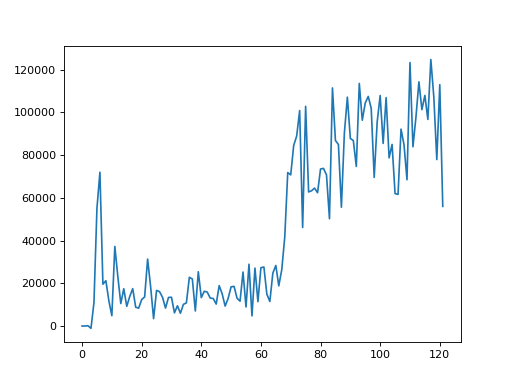

<IPython.core.display.Javascript object>


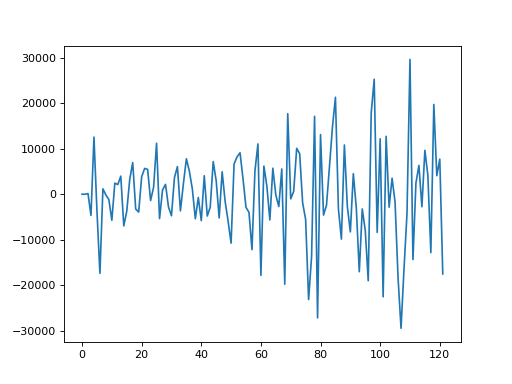

<IPython.core.display.Javascript object>


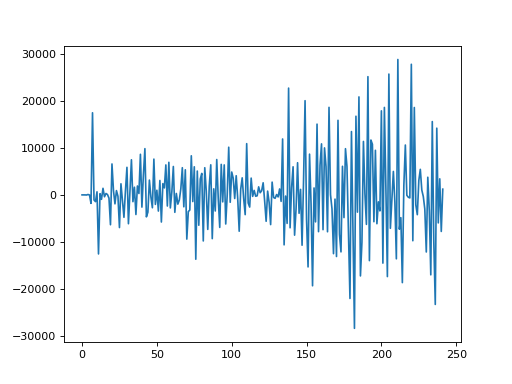

<IPython.core.display.Javascript object>


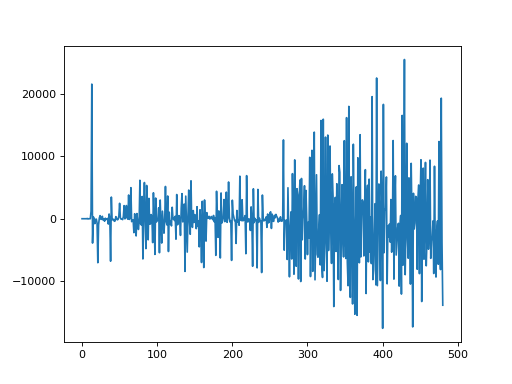

<IPython.core.display.Javascript object>


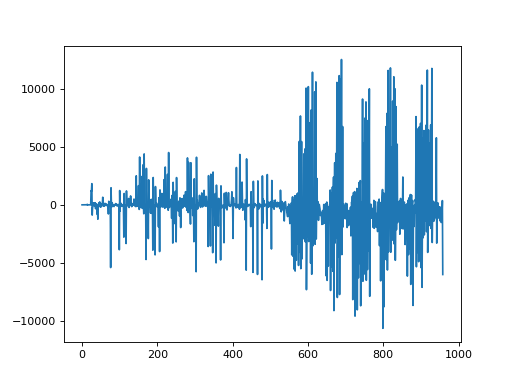

<IPython.core.display.Javascript object>


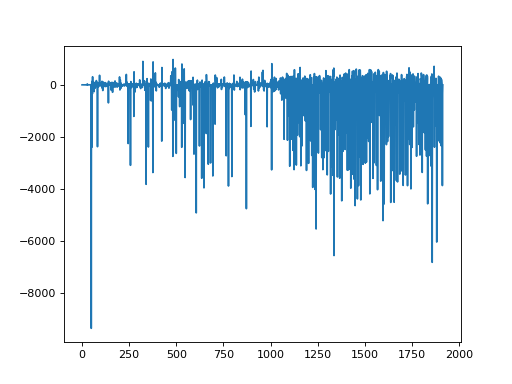

In [98]:
for i in coeffs:
    plt.figure()
    plt.plot(i)

<IPython.core.display.Javascript object>


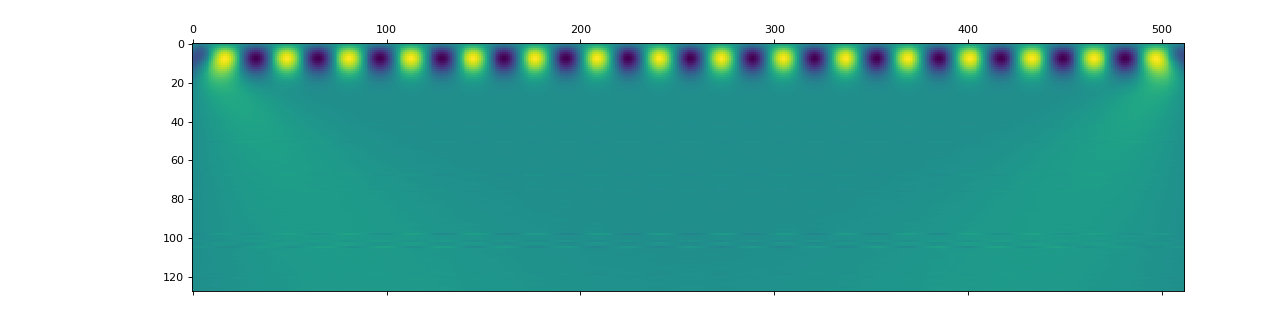

In [51]:
x = np.arange(512)
y = np.sin(2*np.pi*x/32)
coef, freqs=pywt.cwt(y,np.arange(1,129),'gaus1')
plt.matshow(coef)

In [37]:
print(pywt.idwt(ca, cd, 'db2'))

[5.31769800e+00 7.93663168e+00 9.83321953e+00 ... 7.78412744e+03
 8.74003613e+03 1.06158408e+04]


In [38]:
datacube[:,7,7]

array([5.3176980e+00, 7.9366317e+00, 9.8332195e+00, ..., 7.7841274e+03,
       8.7400361e+03, 1.0615841e+04], dtype=float32)

In [94]:
len(coeffs[-1])

1915

<IPython.core.display.Javascript object>


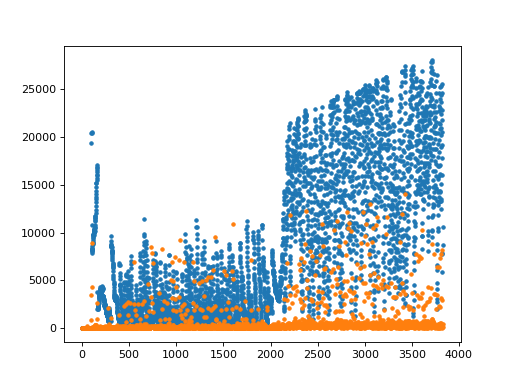

In [532]:
x = np.arange(0,len(coeffs[-1])*2,2)
plt.figure()
#plt.plot(ca)
plt.plot(datacube[np.isfinite(datacube[:,7,7]),7,7],'.')
plt.plot(x,abs(coeffs[-1]),'.')

#plt.ylim(-100,300)

In [ ]:
pywt.scale2frequency()

In [57]:
from scipy import signal

<IPython.core.display.Javascript object>


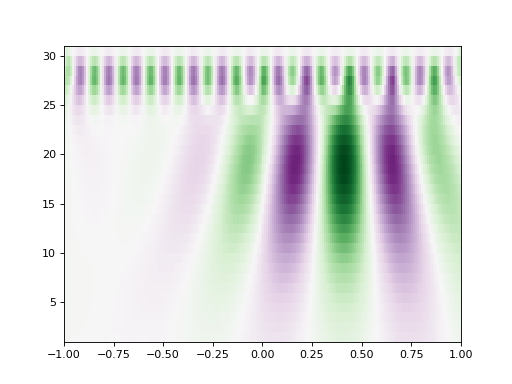

In [58]:
t = np.linspace(-1, 1, 200, endpoint=False)
sig  = np.cos(2 * np.pi * 7 * t) + signal.gausspulse(t - 0.4, fc=2)
widths = np.arange(1, 31)
cwtmatr = signal.cwt(sig, signal.ricker, widths)
plt.figure()
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())

In [121]:
coeffs = pywt.wavedec(datacube[np.isfinite(datacube[:,7,7]),7,7], 'db2',level=5)
coeffs[-1][:] = 0
coeffs[-2][:] = 0
coeffs[-3][:] = 0
coeffs[-4][:] = 0
coeffs[0][:] = 0

In [122]:
db1 = pywt.Wavelet('db2')
test = pywt.waverec(coeffs, db1)

<IPython.core.display.Javascript object>


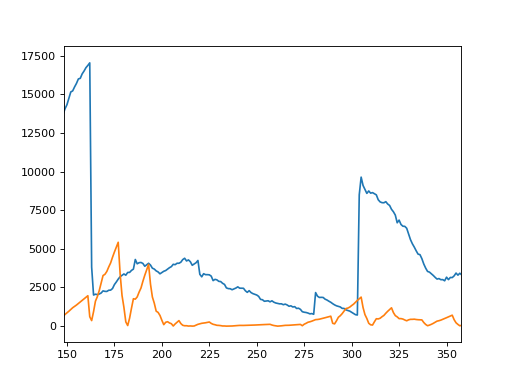

In [125]:
plt.figure()
plt.plot(datacube[np.isfinite(datacube[:,7,7]),7,7])
plt.plot(abs(test))

In [124]:
from scipy.interpolate import CubicSpline

<IPython.core.display.Javascript object>


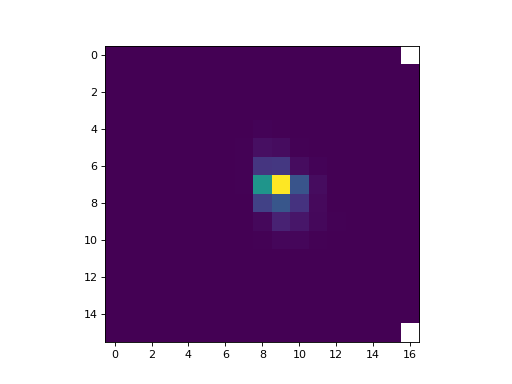

In [386]:
plt.figure()
plt.imshow(datacube[1000])

In [373]:
allflux = np.nansum(datacube,axis=0)
np.where(np.nanmax(allflux) == allflux)

(array([7]), array([8]))

In [530]:
nonan = datacube[np.isfinite(datacube[:,7,8]),7,8]
nonanthrust = thrusters[thrusters == np.where(~np.isfinite(datacube[:,7,8]))[0]]
coeffs = pywt.wavedec(nonan, 'db2',level=20)
eh = abs(coeffs[-1][:-1])# / nonan[::2]

peaks = find_peaks(eh,distance=4,prominence=np.mean(eh))[0]

In [531]:
peaks

array([  51,   81,  140,  152,  198,  222,  234,  245,  257,  275,  281,
        287,  299,  305,  317,  329,  340,  352,  364,  370,  376,  406,
        423,  435,  441,  453,  459,  471,  476,  482,  494,  500,  512,
        518,  524,  529,  541,  547,  559,  577,  588,  594,  606,  623,
        635,  647,  659,  670,  682,  694,  706,  712,  736,  754,  765,
        777,  795,  801,  819,  837,  849,  866,  896,  908,  932,  982,
       1071, 1089, 1095, 1101, 1113, 1119, 1125, 1131, 1137, 1143, 1149,
       1154, 1160, 1166, 1178, 1184, 1190, 1196, 1212, 1218, 1236, 1242,
       1247, 1253, 1265, 1271, 1277, 1283, 1289, 1295, 1301, 1319, 1325,
       1331, 1337, 1342, 1348, 1354, 1360, 1366, 1378, 1384, 1389, 1395,
       1401, 1407, 1413, 1419, 1425, 1431, 1437, 1443, 1449, 1461, 1467,
       1473, 1479, 1490, 1496, 1502, 1508, 1514, 1520, 1526, 1537, 1543,
       1549, 1561, 1567, 1573, 1585, 1591, 1597, 1603, 1614, 1620, 1638,
       1644, 1650, 1656, 1662, 1668, 1673, 1685, 16

<IPython.core.display.Javascript object>


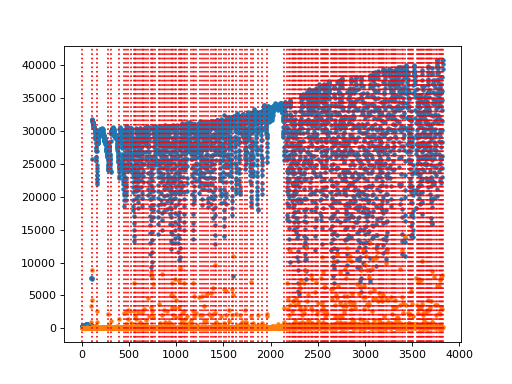

In [535]:
plt.figure()
plt.plot(nonan,'.')#/np.median(nonan))
plt.plot(x[:-1],eh,'.')
#for p in peaks:
#    plt.axvline(x[p],color='m',ls='--')
    
#plt.plot(x[1:-1],abs(np.diff(eh)))

#for v in np.where((q==1048576) | (q==524288))[0]:
#    plt.axvline(v,color='k',ls=':')

for r in realt:
    plt.axvline(r,color='r',ls=':')
#plt.xlim(650,710)

In [502]:
realt

array([   0,   51,   81,  103,  140,  152,  163,  198,  222,  234,  245,
        257,  275,  281,  287,  299,  304,  317,  329,  340,  352,  364,
        370,  376,  396,  406,  423,  435,  444,  453,  459,  468,  476,
        482,  491,  500,  515,  524,  529,  541,  547,  551,  559,  577,
        588,  594,  598,  606,  610,  623,  634,  646,  658,  670,  681,
        694,  705,  712,  729,  736,  741,  754,  765,  776,  795,  801,
        812,  819,  824,  837,  849,  866,  870,  882,  896,  906,  918,
        932,  953,  965,  982,  989, 1001, 1025, 1048, 1059, 1071, 1083,
       1089, 1095, 1101, 1113, 1118, 1125, 1131, 1137, 1143, 1149, 1153,
       1160, 1166, 1177, 1184, 1189, 1196, 1213, 1218, 1236, 1242, 1247,
       1253, 1265, 1271, 1277, 1283, 1289, 1295, 1301, 1319, 1325, 1331,
       1337, 1341, 1348, 1354, 1360, 1365, 1378, 1384, 1389, 1395, 1401,
       1407, 1413, 1419, 1424, 1431, 1437, 1443, 1448, 1461, 1467, 1472,
       1479, 1490, 1496, 1502, 1508, 1514, 1520, 15

In [516]:
realt = np.where((q==1048576) | (q==524288))[0]

In [517]:
realt

array([   0,  103,  163,  304,  396,  444,  468,  491,  515,  551,  598,
        610,  634,  646,  658,  681,  705,  729,  741,  776,  812,  824,
        870,  882,  906,  918,  953,  965,  989, 1001, 1025, 1048, 1059,
       1083, 1095, 1118, 1153, 1177, 1189, 1213, 1247, 1271, 1295, 1341,
       1365, 1389, 1424, 1448, 1472, 1531, 1555, 1591, 1638, 1733, 1745,
       1816, 1864, 1912, 1965, 2143, 2179, 2191, 2203, 2226, 2238, 2250,
       2262, 2274, 2286, 2298, 2309, 2321, 2333, 2357, 2369, 2381, 2404,
       2425, 2437, 2448, 2472, 2495, 2507, 2531, 2543, 2555, 2567, 2590,
       2602, 2614, 2638, 2650, 2662, 2685, 2697, 2709, 2721, 2733, 2744,
       2756, 2779, 2791, 2803, 2815, 2827, 2839, 2851, 2874, 2886, 2898,
       2922, 2934, 2946, 2958, 2981, 2993, 3005, 3017, 3029, 3053, 3075,
       3087, 3099, 3123, 3135, 3158, 3170, 3182, 3194, 3206, 3229, 3252,
       3276, 3288, 3300, 3312, 3324, 3347, 3371, 3395, 3407, 3466, 3490,
       3502, 3514, 3549, 3561, 3573, 3585, 3597, 36

In [510]:
peaks

array([  51,   81,  140,  152,  198,  222,  234,  245,  257,  275,  281,
        287,  299,  305,  317,  329,  340,  352,  364,  370,  376,  406,
        423,  435,  441,  453,  459,  471,  476,  482,  494,  500,  512,
        518,  524,  529,  541,  547,  559,  577,  588,  594,  606,  623,
        635,  647,  659,  670,  682,  694,  706,  712,  736,  754,  765,
        777,  795,  801,  819,  837,  849,  866,  896,  908,  932,  982,
       1071, 1089, 1095, 1101, 1113, 1119, 1125, 1131, 1137, 1143, 1149,
       1154, 1160, 1166, 1178, 1184, 1190, 1196, 1212, 1218, 1236, 1242,
       1247, 1253, 1265, 1271, 1277, 1283, 1289, 1295, 1301, 1319, 1325,
       1331, 1337, 1342, 1348, 1354, 1360, 1366, 1378, 1384, 1389, 1395,
       1401, 1407, 1413, 1419, 1425, 1431, 1437, 1443, 1449, 1461, 1467,
       1473, 1479, 1490, 1496, 1502, 1508, 1514, 1520, 1526, 1537, 1543,
       1549, 1561, 1567, 1573, 1585, 1591, 1597, 1603, 1614, 1620, 1638,
       1644, 1650, 1656, 1662, 1668, 1673, 1685, 16

In [601]:
datacube.shape

(4022, 16, 17)

In [602]:
ind1

array([7])

In [606]:
np.isfinite(datacube[:,ind1,ind2])

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [613]:
ind1[0]

7

In [616]:
allflux = np.nansum(datacube,axis=0)
ind1, ind2 = np.where(np.nanmax(allflux) == allflux)

nonan = datacube[np.isfinite(datacube[:,ind1[0],ind2[0]]),ind1[0],ind2[0]]
nonaninds = np.where(np.isfinite(datacube[:,ind1[0],ind2[0]]))[0]
coeffs = pywt.wavedec(nonan, 'db2',level=20)
eh = abs(coeffs[-1][:-1])# / nonan[::2]
eh_x = np.arange(0,len(coeffs[-1])*2,2)
peaks = find_peaks(eh,distance=4,prominence=np.mean(eh))[0]

peaks = nonaninds[eh_x[peaks]]

realt = np.where((Qual==1048576) | (Qual==524288))[0]
for p in peaks:
    if ~np.isclose(p, realt, atol=3).any():
        realt = np.append(realt, p)
        
realt = np.sort(realt)

In [617]:
realt

array([   0,  105,  165,  284,  309,  405,  453,  478,  501,  525,  561,
        572,  585,  609,  621,  645,  657,  670,  693,  717,  741,  753,
        764,  789,  825,  837,  860,  885,  897,  921,  933,  958,  969,
        981, 1005, 1017, 1041, 1052, 1065, 1077, 1101, 1113, 1137, 1173,
       1197, 1209, 1233, 1269, 1293, 1317, 1340, 1365, 1389, 1413, 1436,
       1449, 1473, 1497, 1534, 1557, 1581, 1617, 1628, 1665, 1701, 1726,
       1761, 1773, 1820, 1845, 1893, 1941, 2133, 2313, 2349, 2361, 2374,
       2397, 2409, 2421, 2433, 2445, 2457, 2470, 2481, 2493, 2505, 2529,
       2541, 2553, 2564, 2577, 2601, 2613, 2625, 2649, 2662, 2673, 2685,
       2709, 2721, 2733, 2745, 2756, 2769, 2781, 2793, 2817, 2829, 2841,
       2854, 2865, 2877, 2889, 2901, 2913, 2925, 2937, 2950, 2961, 2973,
       2985, 2997, 3009, 3021, 3033, 3044, 3057, 3069, 3081, 3105, 3117,
       3129, 3142, 3165, 3177, 3189, 3201, 3213, 3224, 3238, 3261, 3273,
       3285, 3309, 3321, 3332, 3345, 3357, 3369, 33

In [709]:
def Regress_fit(Data):
    ind = np.where(np.isfinite(Data))[0]
    x = np.arange(0,len(Data))
    x = x[ind]
    y = Data[ind]
    if len(y) >= 3:
        x = x[:, np.newaxis]
        y = y[:, np.newaxis]

        polynomial_features= PolynomialFeatures(degree=6)
        x_poly = polynomial_features.fit_transform(x)

        model = LinearRegression()
        model.fit(x_poly, y)
        y_poly_pred = model.predict(x_poly)

        rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
        r2 = r2_score(y,y_poly_pred)

        sort_axis = operator.itemgetter(0)
        sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
        x, y_poly_pred = zip(*sorted_zip)

        mod = np.zeros_like(y)
        for i in range(len(mod)):
            mod[i] = y_poly_pred[i][0]
    else:
        mod = np.zeros_like(y)
        mod[:] = np.nan
    fit = Data.copy()

    fit[ind] = np.squeeze(mod)

    return fit

In [710]:
from scipy.interpolate import interp1d

def Correct_motion(Data, Distance, Thrust):
    data = Data.copy()
    data[Thrust] = np.nan
    data[Thrust[:-1]+1] = np.nan
    data[Thrust[:-1]+2] = np.nan
    data[Thrust[1:]-1] = np.nan
    X, Y = np.where(np.nansum(data,axis=0) > 0)
    
    fits = data.copy()
    spline = data.copy()
    x = np.arange(data.shape[0])
    for j in range(len(X)):
        trend = []
        for i in range(len(Thrust)-1):
            section = data[Thrust[i]:Thrust[i+1]-1,X[j],Y[j]].copy()
    
            fits[Thrust[i]:Thrust[i+1]-1,X[j],Y[j]] = Regress_fit(section)

            d = Distance[Thrust[i]:Thrust[i+1]-1]
            ind = np.where(np.isfinite(section))[0]

            if (d[ind] <= 0.2).any():
                mind = np.nanmin(d[ind])
                ind2 = np.where(d[ind] == mind)[0][0]
                trend += [[ind[ind2]+Thrust[i],section[ind[ind2]]]]

        trend = np.array(trend)
        spl = interp1d(trend[:,0], trend[:,1], kind = 'linear',bounds_error=False)
        x = np.arange(data.shape[0])
        spl = spl(x)
        
        spline[:,X[j],Y[j]] = spl
    data = data - (fits ) + spline
    
    return data, fits, spline

In [711]:
d, f, s = Correct_motion(datacube,distdrif,realt)

<IPython.core.display.Javascript object>


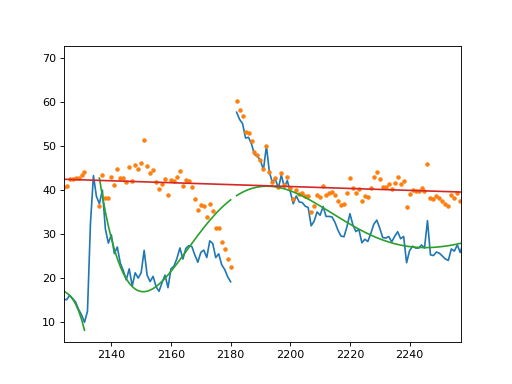

In [712]:
plt.figure()
plt.plot(datacube[:,6,6])
plt.plot(d[:,6,6],'.')
plt.plot(f[:,6,6])
plt.plot(s[:,6,6])

In [713]:
np.where((X==6) & (Y==6))

(array([65]),)

In [714]:
Thrust = realt.copy()
data = datacube.copy()
Distance = distdrif.copy()

data[Thrust] = np.nan
data[Thrust[:-1]+1] = np.nan
data[Thrust[1:]-1] = np.nan
X, Y = np.where(np.nansum(data,axis=0) > 0)

fits = data.copy()
spline = data.copy()

j = 65
trend = []
for i in range(len(Thrust)-1):
    section = data[Thrust[i]:Thrust[i+1]-1,X[j],Y[j]].copy()
    
    fits[Thrust[i]:Thrust[i+1]-1,X[j],Y[j]] = Regress_fit(section)

    d = Distance[Thrust[i]:Thrust[i+1]-1]
    ind = np.where(np.isfinite(section))[0]

    if (d[ind] <= 0.2).any():
        mind = np.nanmin(d[ind])
        ind2 = np.where(d[ind] == mind)[0][0]
        trend += [[ind[ind2]+Thrust[i],section[ind[ind2]]]]

trend = np.array(trend)
spl = interp1d(trend[:,0], trend[:,1], kind = 'linear',bounds_error=False)
x = np.arange(data.shape[0])
spline = spl(x)

<IPython.core.display.Javascript object>


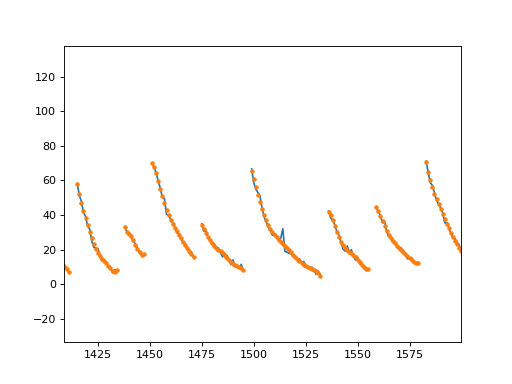

In [720]:
plt.figure()
plt.plot(data[:,6,6])
plt.plot(fits[:,6,6],'.')
#plt.plot(spline,'.')


In [673]:
trend

array([[ 1.12000000e+02, -1.04953289e+00],
       [ 2.16000000e+02, -2.84835577e-01],
       [ 3.35000000e+02, -2.06137466e+00],
       [ 4.07000000e+02,  9.77571309e-01],
       [ 4.55000000e+02, -1.66095957e-01],
       [ 4.80000000e+02, -9.58342612e-01],
       [ 5.03000000e+02,  7.99313903e-01],
       [ 5.28000000e+02, -7.60092854e-01],
       [ 5.63000000e+02,  6.31747544e-01],
       [ 5.87000000e+02,  3.81286055e-01],
       [ 6.11000000e+02, -1.96477449e+00],
       [ 6.24000000e+02, -1.65246165e+00],
       [ 6.47000000e+02,  3.29027534e-01],
       [ 6.61000000e+02, -1.55887949e+00],
       [ 6.79000000e+02, -1.51160693e+00],
       [ 6.99000000e+02,  9.39496309e-02],
       [ 7.19000000e+02, -6.62707090e-01],
       [ 7.68000000e+02, -2.24182701e+00],
       [ 7.96000000e+02, -2.03560352e-01],
       [ 8.27000000e+02, -1.22513628e+00],
       [ 8.39000000e+02, -1.46366671e-01],
       [ 8.62000000e+02, -1.09948061e-01],
       [ 8.87000000e+02,  1.72686613e+00],
       [ 8.

<IPython.core.display.Javascript object>


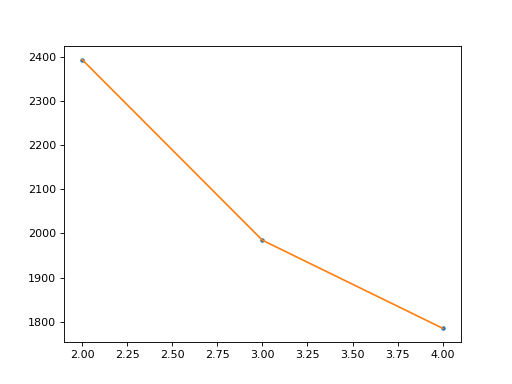

In [489]:
corr = test[:,7,7].copy()
i = 130
plt.figure()
plt.plot(corr[realt[i]:realt[i+1]-1],'.')
plt.plot(Regress_fit(corr[realt[i]:realt[i+1]-1]))

In [523]:
realt

array([   0,  103,  163,  280,  304,  396,  444,  468,  491,  515,  551,
        562,  574,  598,  610,  634,  646,  658,  681,  705,  729,  741,
        752,  776,  812,  824,  846,  870,  882,  906,  918,  942,  953,
        965,  989, 1001, 1025, 1036, 1048, 1059, 1083, 1095, 1118, 1153,
       1177, 1189, 1213, 1247, 1271, 1295, 1318, 1341, 1365, 1389, 1412,
       1424, 1448, 1472, 1508, 1531, 1555, 1591, 1602, 1638, 1674, 1698,
       1733, 1745, 1792, 1816, 1864, 1912, 1965, 2143, 2179, 2191, 2203,
       2226, 2238, 2250, 2262, 2274, 2286, 2298, 2309, 2321, 2333, 2357,
       2369, 2381, 2392, 2404, 2425, 2437, 2448, 2472, 2484, 2495, 2507,
       2531, 2543, 2555, 2567, 2578, 2590, 2602, 2614, 2638, 2650, 2662,
       2674, 2685, 2697, 2709, 2721, 2733, 2744, 2756, 2768, 2779, 2791,
       2803, 2815, 2827, 2839, 2851, 2862, 2874, 2886, 2898, 2922, 2934,
       2946, 2958, 2981, 2993, 3005, 3017, 3029, 3040, 3053, 3075, 3087,
       3099, 3123, 3135, 3146, 3158, 3170, 3182, 31

<IPython.core.display.Javascript object>


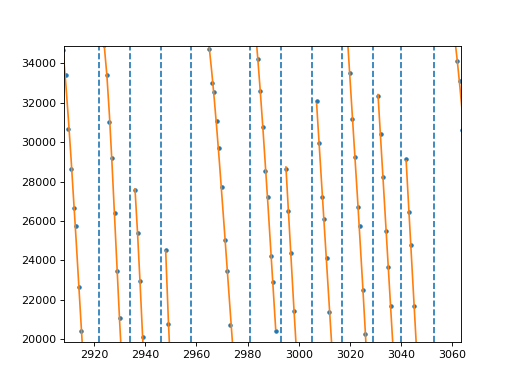

In [549]:
plt.figure()
plt.plot(test,'.')
plt.plot(corr)
for t in realt:
    plt.axvline(t,ls='--')

In [545]:
x[peaks]

array([ 102,  162,  280,  304,  396,  444,  468,  490,  514,  550,  562,
        574,  598,  610,  634,  658,  680,  704,  728,  740,  752,  812,
        846,  870,  882,  906,  918,  942,  952,  964,  988, 1000, 1024,
       1036, 1048, 1058, 1082, 1094, 1118, 1154, 1176, 1188, 1212, 1246,
       1270, 1294, 1318, 1340, 1364, 1388, 1412, 1424, 1472, 1508, 1530,
       1554, 1590, 1602, 1638, 1674, 1698, 1732, 1792, 1816, 1864, 1964,
       2142, 2178, 2190, 2202, 2226, 2238, 2250, 2262, 2274, 2286, 2298,
       2308, 2320, 2332, 2356, 2368, 2380, 2392, 2424, 2436, 2472, 2484,
       2494, 2506, 2530, 2542, 2554, 2566, 2578, 2590, 2602, 2638, 2650,
       2662, 2674, 2684, 2696, 2708, 2720, 2732, 2756, 2768, 2778, 2790,
       2802, 2814, 2826, 2838, 2850, 2862, 2874, 2886, 2898, 2922, 2934,
       2946, 2958, 2980, 2992, 3004, 3016, 3028, 3040, 3052, 3074, 3086,
       3098, 3122, 3134, 3146, 3170, 3182, 3194, 3206, 3228, 3240, 3276,
       3288, 3300, 3312, 3324, 3336, 3346, 3370, 33

<IPython.core.display.Javascript object>


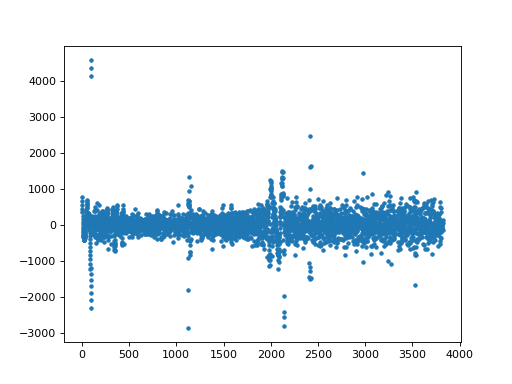

In [550]:
plt.figure()
plt.plot(test-corr,'.')

In [341]:
p1 - p2

array([ 5.79356653e+00,  2.60814580e+00,  1.15934895e+00, ...,
       -8.33476194e+03, -3.54395369e+03, -2.98621436e+02])

In [347]:
find_peaks(p2,distance=4,prominence=np.median(eh)*3)[0]

array([  49,   81,   93,  140,  152,  198,  222,  234,  245,  257,  275,
        287,  299,  305,  317,  323,  329,  340,  352,  364,  370,  376,
        388,  406,  412,  423,  435,  441,  453,  459,  471,  476,  482,
        494,  500,  512,  518,  524,  529,  541,  547,  559,  565,  577,
        588,  594,  606,  623,  635,  647,  659,  670,  682,  694,  706,
        724,  736,  754,  765,  777,  795,  802,  806,  819,  837,  849,
        866,  872,  896,  908,  932,  956,  960,  982, 1006, 1054, 1060,
       1071, 1083, 1089, 1095, 1101, 1113, 1119, 1125, 1131, 1137, 1143,
       1149, 1154, 1160, 1166, 1178, 1184, 1190, 1196, 1202, 1212, 1218,
       1224, 1236, 1242, 1247, 1253, 1265, 1271, 1277, 1283, 1289, 1295,
       1301, 1307, 1319, 1325, 1331, 1337, 1342, 1348, 1354, 1360, 1366,
       1372, 1378, 1384, 1389, 1395, 1401, 1407, 1413, 1419, 1425, 1431,
       1437, 1443, 1449, 1455, 1461, 1467, 1473, 1479, 1490, 1496, 1502,
       1508, 1514, 1520, 1526, 1532, 1537, 1543, 15

In [340]:
p2 = eh

In [338]:
p1 = eh

In [156]:
from scipy.signal import find_peaks

In [329]:
eh = abs(coeffs[-1][:-1])# / nonan[::2]
x = np.arange(0,len(coeffs[-1])*2,2)
peaks = find_peaks(eh,distance=4,prominence=np.median(eh)*2)[0]#height=[np.median(eh)*2,1e5])[0]

In [308]:
np.diff(peaks)

array([ 6,  6, 14, 11,  9, 33, 11, 17, 30, 12, 10, 13, 13, 10,  8, 16, 12,
       11, 12, 18,  6,  6, 12,  6,  6,  6,  6,  6, 11, 12, 12,  6,  6, 12,
        6, 12,  6, 11, 12,  6, 12,  6,  7, 10,  6, 12,  6, 12,  6, 11, 12,
        6, 12,  6, 11, 12,  6, 12,  7, 10, 12, 12, 12, 11, 12, 12, 12, 18,
       12,  9,  9, 11, 12, 18,  7,  6, 11, 11,  7, 12, 11,  6,  6, 24, 12,
        8, 16,  6, 18, 10, 16,  8, 16, 15,  9, 13, 11,  6, 12, 17,  6,  7,
       11,  6,  6,  6,  6,  6, 11,  7,  6, 11,  6,  7, 11, 10, 12, 12,  6,
        6,  6, 11,  7,  6,  6, 11,  6,  6, 12,  6,  6,  6, 11,  7, 12, 11,
        6, 11,  6,  7,  6,  6,  6, 11,  6,  6, 12,  6,  6,  6, 12, 12,  6,
       11,  7, 10,  7,  6, 12,  6, 11,  6,  6,  6,  6, 11,  6,  6, 12,  6,
        6,  6, 12,  6, 12, 12,  6, 12, 11,  6,  6,  6,  6,  7, 16,  6,  6,
        6,  6,  7, 11,  6,  6,  6,  6,  6,  6,  6, 11,  6,  7, 11,  6,  6,
        7])

In [309]:
Qual = hdu[1].data.field('QUALITY')
q = Qual[np.isfinite(datacube[:,7,7])]
thrusters = np.where((q == 1048576) | (q == 1089568) | (q == 1056768) | (q == 1064960) | (q == 1081376) | (q == 10240) | (q == 32768) | (q == 1097760) | (q == 1048580) | (q == 1081348))[0]
thrusters = np.insert(thrusters,0,-1)
thrusters = np.append(thrusters,len(datacube)-2)

In [310]:
thrusters

array([  -1,  103,  163,  304,  396,  444,  468,  491,  515,  551,  574,
        598,  610,  634,  646,  658,  681,  705,  729,  741,  776,  812,
        824,  870,  882,  906,  918,  953,  965,  989, 1001, 1025, 1048,
       1059, 1083, 1095, 1118, 1153, 1177, 1189, 1213, 1247, 1271, 1295,
       1341, 1365, 1389, 1424, 1448, 1472, 1531, 1555, 1591, 1638, 1674,
       1733, 1745, 1816, 1864, 1912, 1965, 2143, 2179, 2191, 2203, 2226,
       2238, 2250, 2262, 2274, 2286, 2298, 2309, 2321, 2333, 2357, 2369,
       2381, 2404, 2425, 2437, 2448, 2472, 2495, 2507, 2531, 2543, 2555,
       2567, 2590, 2602, 2614, 2638, 2650, 2662, 2685, 2697, 2709, 2721,
       2733, 2744, 2756, 2779, 2791, 2803, 2815, 2827, 2839, 2851, 2874,
       2886, 2898, 2922, 2934, 2946, 2958, 2981, 2993, 3005, 3017, 3028,
       3029, 3041, 3053, 3075, 3087, 3099, 3123, 3135, 3158, 3170, 3182,
       3194, 3206, 3229, 3252, 3276, 3288, 3300, 3312, 3324, 3347, 3371,
       3394, 3395, 3407, 3454, 3466, 3478, 3490, 35

<IPython.core.display.Javascript object>


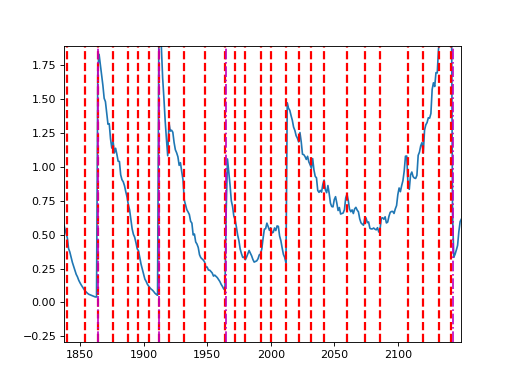

In [331]:
plt.figure()
plt.plot(nonan/np.median(nonan))
#plt.plot(x[:-1],eh)
for p in peaks:
    #plt.plot(x[p],eh[p],'r*')
    plt.axvline(x[p],color='r',ls='--',lw=2)

for t in thrusters:
    #plt.plot(x[p],eh[p],'r*')
    plt.axvline(t,color='m',ls='-.')

#for v in np.where(q>0)[0]:
#    plt.axvline(v,color='k',ls=':')
#plt.ylim(-.5,1.5)
#plt.xlim(1030,1070)

In [182]:
np.median(eh)*2

0.03978965276045035

In [202]:
breaks = x[peaks].copy()
breaks = np.insert(breaks,0,0)
breaks = np.insert(breaks,len(breaks),len(nonan)-1)

In [203]:
breaks

array([   0,   10,   18,   30,   58,   80,   88,   98,  164,  186,  220,
        280,  304,  324,  350,  376,  396,  412,  444,  468,  490,  514,
        550,  562,  574,  584,  598,  610,  622,  634,  646,  658,  680,
        690,  704,  728,  740,  752,  776,  788,  812,  824,  836,  846,
        870,  882,  896,  906,  918,  932,  942,  952,  964,  988, 1000,
       1010, 1024, 1036, 1048, 1058, 1082, 1094, 1118, 1130, 1144, 1152,
       1166, 1176, 1188, 1212, 1226, 1236, 1246, 1270, 1294, 1318, 1340,
       1364, 1378, 1388, 1398, 1412, 1438, 1448, 1472, 1490, 1508, 1522,
       1530, 1554, 1590, 1604, 1612, 1628, 1638, 1666, 1674, 1698, 1720,
       1732, 1744, 1792, 1816, 1832, 1840, 1864, 1876, 1912, 1920, 1932,
       1964, 1980, 2012, 2032, 2042, 2060, 2086, 2108, 2120, 2144, 2152,
       2178, 2190, 2204, 2226, 2238, 2250, 2262, 2274, 2286, 2298, 2308,
       2322, 2334, 2356, 2368, 2382, 2392, 2404, 2412, 2424, 2438, 2448,
       2472, 2484, 2496, 2508, 2530, 2544, 2556, 25

In [195]:
len(nonan)

3828

In [205]:
nonan[3827]

10615.841

In [206]:
tt = np.arange(0,len(nonan))

In [208]:
fun = CubicSpline(tt[0:10],nonan[0:10])

In [209]:
fun(tt[0:10])

array([ 5.317698  ,  7.93663168,  9.83321953, 10.42391396, 12.90464783,
       13.07714081, 16.77957535, 15.01100349, 15.23294926, 13.73877907])

In [211]:
nonan[0:10]

array([ 5.317698 ,  7.9366317,  9.83322  , 10.423914 , 12.904648 ,
       13.077141 , 16.779575 , 15.0110035, 15.232949 , 13.738779 ],
      dtype=float32)

In [217]:
cor = np.zeros_like(nonan)
tt = np.arange(0,len(nonan))
for i in range(len(breaks)-1):
    fun = CubicSpline(tt[breaks[i]:breaks[i+1]],nonan[breaks[i]:breaks[i+1]])
    cor[breaks[i]:breaks[i+1]] = fun(tt[breaks[i]:breaks[i+1]])

<IPython.core.display.Javascript object>


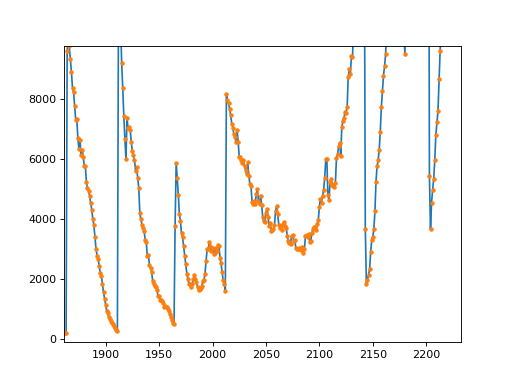

In [221]:
plt.figure()
plt.plot(nonan)
plt.plot(cor,'.')


<IPython.core.display.Javascript object>


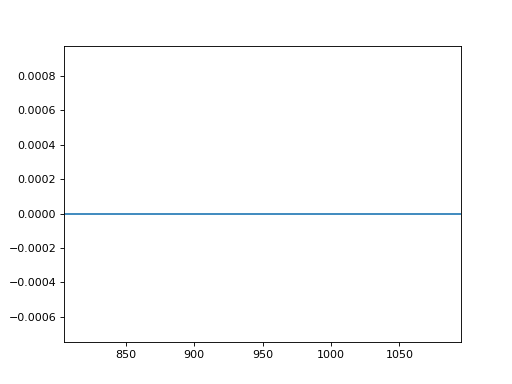

In [219]:
plt.figure()
plt.plot(nonan[:-1]-cor[:-1])

In [222]:
nonan[:-1]-cor[:-1]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [229]:
i = 100
fun = CubicSpline(tt[breaks[i]+1:breaks[i+1]+1],nonan[breaks[i]+1:breaks[i+1]+1])
cor[breaks[i]+1:breaks[i+1]+1] = fun(tt[breaks[i]+1:breaks[i+1]+1])

<IPython.core.display.Javascript object>


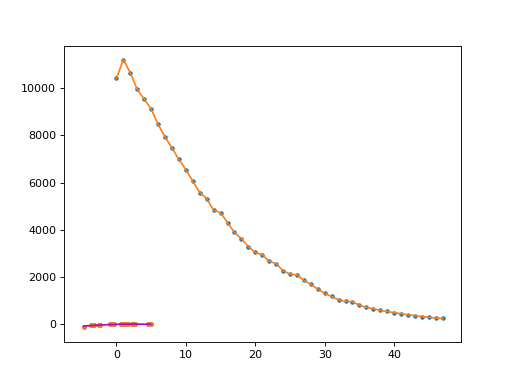

In [230]:
plt.figure()
plt.plot(nonan[breaks[i]+1:breaks[i+1]+1],'.')
plt.plot(fun(tt[breaks[i]+1:breaks[i+1]+1]))

In [280]:
i =230
x = tt[breaks[i]+1:breaks[i+1]+1]
y = nonan[breaks[i]+1:breaks[i+1]+1]
x = tt[breaks[i]:breaks[i+1]]
y = nonan[breaks[i]:breaks[i+1]]

In [435]:
def Regress_fit(Data):
    ind = np.isfinite(Data)[0]
    x = np.arange(0,len(Data[ind]))
    y = Data[ind]
    x = x[:, np.newaxis]
    y = y[:, np.newaxis]

    polynomial_features= PolynomialFeatures(degree=3)
    x_poly = polynomial_features.fit_transform(x)

    model = LinearRegression()
    model.fit(x_poly, y)
    y_poly_pred = model.predict(x_poly)

    rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
    r2 = r2_score(y,y_poly_pred)
                  
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
    x, y_poly_pred = zip(*sorted_zip)
    
    mod = np.zeros_like(y)
    for i in range(len(mod)):
        mod[i] = y_poly_pred[i][0]
    fit = Data.copy()
    fit[ind] = mod
    return fit

320.9302592940675
0.9921645314098577


<IPython.core.display.Javascript object>


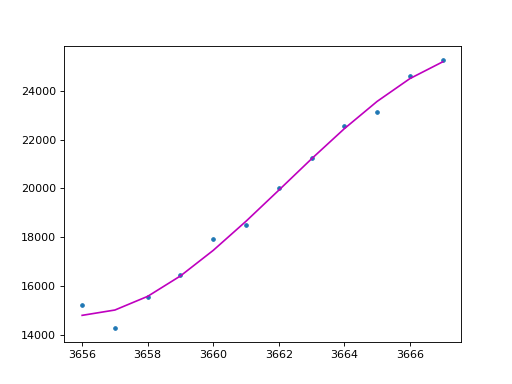

In [281]:
import operator

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

np.random.seed(0)
#x = 2 - 3 * np.random.normal(0, 1, 20)
#y = x - 2 * (x ** 2) + 0.5 * (x ** 3) + np.random.normal(-3, 3, 20)

# transforming the data to include another axis
x = x[:, np.newaxis]
y = y[:, np.newaxis]

polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)
plt.figure()
plt.scatter(x, y, s=10)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)

plt.plot(x, y_poly_pred, color='m')
plt.show()

In [267]:
y.shape

(48, 1)

In [255]:
y_poly_pred[0][0]
mod = np.zeros_like(y)

for i in range(len(mod)):
    mod[i] = y_poly_pred[i][0]

<IPython.core.display.Javascript object>


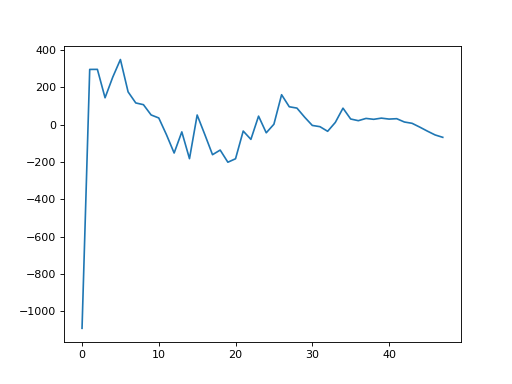

In [256]:
plt.figure()
plt.plot(y-mod)

In [282]:
tt[breaks]

array([   0,   10,   18,   30,   58,   80,   88,   98,  164,  186,  220,
        280,  304,  324,  350,  376,  396,  412,  444,  468,  490,  514,
        550,  562,  574,  584,  598,  610,  622,  634,  646,  658,  680,
        690,  704,  728,  740,  752,  776,  788,  812,  824,  836,  846,
        870,  882,  896,  906,  918,  932,  942,  952,  964,  988, 1000,
       1010, 1024, 1036, 1048, 1058, 1082, 1094, 1118, 1130, 1144, 1152,
       1166, 1176, 1188, 1212, 1226, 1236, 1246, 1270, 1294, 1318, 1340,
       1364, 1378, 1388, 1398, 1412, 1438, 1448, 1472, 1490, 1508, 1522,
       1530, 1554, 1590, 1604, 1612, 1628, 1638, 1666, 1674, 1698, 1720,
       1732, 1744, 1792, 1816, 1832, 1840, 1864, 1876, 1912, 1920, 1932,
       1964, 1980, 2012, 2032, 2042, 2060, 2086, 2108, 2120, 2144, 2152,
       2178, 2190, 2204, 2226, 2238, 2250, 2262, 2274, 2286, 2298, 2308,
       2322, 2334, 2356, 2368, 2382, 2392, 2404, 2412, 2424, 2438, 2448,
       2472, 2484, 2496, 2508, 2530, 2544, 2556, 25

In [283]:
thrusters

array([  -1,  105,  165,  189,  285,  309,  381,  405,  453,  477,  478,
        501,  525,  561,  573,  585,  609,  621,  645,  657,  669,  670,
        693,  717,  741,  753,  765,  789,  825,  837,  861,  885,  897,
        921,  933,  957,  969,  981, 1005, 1017, 1041, 1053, 1065, 1077,
       1101, 1113, 1137, 1149, 1173, 1197, 1209, 1233, 1245, 1269, 1293,
       1317, 1341, 1365, 1389, 1413, 1437, 1449, 1473, 1497, 1533, 1557,
       1581, 1617, 1629, 1665, 1701, 1725, 1761, 1773, 1821, 1845, 1893,
       1941, 2133, 2181, 2277, 2313, 2349, 2361, 2373, 2374, 2397, 2409,
       2421, 2433, 2445, 2457, 2469, 2470, 2481, 2493, 2505, 2529, 2541,
       2553, 2565, 2577, 2601, 2613, 2625, 2649, 2661, 2673, 2685, 2709,
       2721, 2733, 2745, 2757, 2769, 2781, 2793, 2817, 2829, 2841, 2853,
       2865, 2877, 2889, 2901, 2913, 2925, 2937, 2949, 2961, 2973, 2985,
       2997, 3009, 3021, 3033, 3045, 3057, 3069, 3081, 3105, 3117, 3129,
       3141, 3142, 3165, 3177, 3189, 3201, 3212, 32

<IPython.core.display.Javascript object>


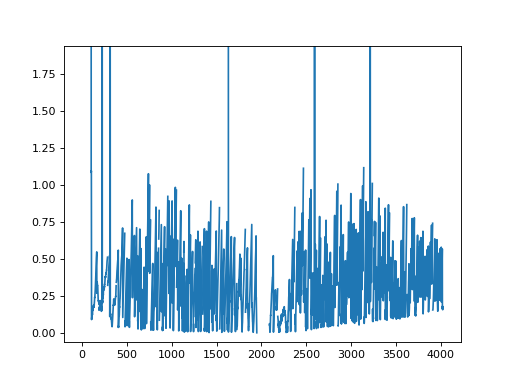

(0, 2)

In [554]:
plt.figure()
plt.plot(distdrif)
plt.ylim(0,2)

<IPython.core.display.Javascript object>


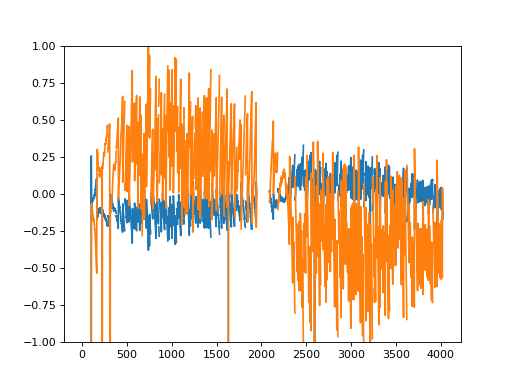

(-1, 1)

In [557]:
plt.figure()
plt.plot(ydrif)
plt.plot(xdrif)
plt.ylim(-1,1)

In [577]:
np.where(distdrif < 0.3)[0]

array([ 105,  106,  107, ..., 4019, 4020, 4021])